# AI6126 ACV Project 1


In [1]:
nb_ver = 1.2
title = f'ai6126-project1-colab-v{nb_ver}'
print(title)
comments = "31"
print(comments)

ai6126-project1-colab-v1.2
31


## Versioning & References

### Changelogs
+ V0.1 - Setup codes to download and unzip celeba to gDrive
+ V0.2 - Added training loop 
+ V0.3 - Added seeding + save/ load checkpoint
+ V0.4 - Added time taken + save output
+ V0.5 - Added RandomErasing to transforms
+ V0.6 - Added get_criterion (FocalLoss) 
+ V0.7 - Added FaceAttrMobileNetV2 & FaceAttrResNeXt
+ V0.8 - Added Albumentations
+ V0.9 - Updated Optimizer (SGD, AdamW works well)
+ V0.91 - Added ModelTimer() + Added more augmentations
+ V1.0 - Added ReduceLROnPlateau Scheduler
+ V1.1 - Updated Augmentations to more closely follow Tricks paper + Added OneCycleLR Scheduler + No bias decay
+ V1.2 - Added Early Stopping

### ToDo:
+ V1.1 - Train with new Augmentations
+ V1.1 - Train with OneCycleLR 
+ V1.1 - Train with no bias decay 
+ Tune weight decay parameter

### References
+ [Face Attribute Prediction on CelebA benchmark with PyTorch Implementation](https://github.com/d-li14/face-attribute-prediction)
+ [PyTorch Transfer Learning](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html)
+ [Albumentations](https://albumentations.ai/)
+ [Focal Loss](https://github.com/kornia/kornia/blob/master/kornia/losses/focal.py)
+ [Bag of Tricks](https://arxiv.org/abs/1812.01187)

### Dependencies

In [2]:
# conda install pytorch torchvision cudatoolkit=10.2 -c pytorch
# conda install matplotlib
# conda install pandas
# conda install tqdm
# conda install -c conda-forge jupyterlab
# conda install -c conda-forge tensorboard
# conda install -c conda-forge protobuf # for tensorboard
# conda install nb_conda_kernels # auto add kernels

# conda install -c conda-forge imgaug
# conda install albumentations -c conda-forge

## Setup/ Configuration

### Colab

In [3]:
# you can choose to mount your Google Drive (optional)
import sys, os
if 'google.colab' in sys.modules:
    from google.colab import drive
    drive.mount('/content/drive')
    file_name = f'ai6126-project1-colab-v{nb_ver}.ipynb'
    print(file_name)
    import subprocess
    path_to_file = subprocess.check_output('find . -type f -name ' + str(file_name), shell=True).decode("utf-8")
    print(path_to_file)
    path_to_file = path_to_file.replace(file_name,"").replace('\n',"")
    os.chdir(path_to_file)
    !pwd

### Download Dataset (JUPYTER ONLY)

In [4]:
import os, glob
local_download_path = '../data/celeba/img_align_celeba'
download_dataset = True
if os.path.exists(local_download_path):
    images = glob.glob(local_download_path + '/*.jpg')
    if len(images) == 202599:
        download_dataset = False
print(f"download celeba dataset: {download_dataset}")

if download_dataset:
    # create dataset root and enter it
    !mkdir -p data/celeba
    %cd data/celeba

    # we have prepared a backup of `img_align_celeba.zip` of Celeb-A dataset in the Dropbox
    # download it directly, or manually download the original file from Google Drive above
    !wget https://www.dropbox.com/s/8kzo40fqx7nodat/img_align_celeba.zip

    # unzip the downloaded file
    !unzip -qq img_align_celeba.zip
    !rm -f img_align_celeba.zip

    # change the directory back to the root
    %cd ../..
    !ls

download celeba dataset: False


## Implementation

### Imports

In [5]:
import sys, os
import shutil
import time
import random
import numpy as np
import copy
from datetime import datetime
from distutils.dir_util import copy_tree #for recursive filecopying

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.tensorboard import SummaryWriter

import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2

from tqdm import tqdm
import matplotlib.pyplot as plt

import config
from celeba_dataset import CelebaDataset
import models
import losses
from utils import Logger, AverageMeter, Bar, ModelTimer, savefig, adjust_learning_rate, accuracy, reset_gpu_cache, print_attribute_acc, create_dir_ifne, add_weight_decay

In [6]:
# check PyTorch version and cuda status
print(torch.__version__, torch.cuda.is_available())

# define device
device = torch.device("cuda:"+config.gpu_id if torch.cuda.is_available() else "cpu")
print(device)

ISJUPYTER = False
if 'ipykernel' in sys.modules:
    ISJUPYTER = True
    # set the backend of matplotlib to the 'inline' backend
    %matplotlib inline
    config.disable_tqdm = False
    
print(f"disable_tqdm: {config.disable_tqdm}")

1.6.0 True
cuda:0
disable_tqdm: False


### Seeding

In [7]:
# set random seed for reproducibility
def seed_everything(seed=None):
    if seed is None:
        seed = random.randint(1, 10000) # create random seed
        print(f'random seed used: {seed}')
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    if 'torch' in sys.modules:
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = True
    
seed_everything(seed=config.manual_seed)

### Data Transform

In [8]:
# Data augmentation and normalization for training
# Just normalization for validation and testing
def load_dataloaders(print_info=True, albu_transforms = True):
    if config.evaluate:
        phases = ['test']
    else:
        phases = ['train', 'val']

    attribute_names = ['5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive', 'Bags_Under_Eyes', 'Bald', 
                       'Bangs', 'Big_Lips', 'Big_Nose', 'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 
                       'Bushy_Eyebrows', 'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair',
                       'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open', 'Mustache', 
                       'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin', 'Pointy_Nose', 'Receding_Hairline',
                       'Rosy_Cheeks', 'Sideburns', 'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings', 
                       'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace', 'Wearing_Necktie', 'Young']
    
    attributes_list = {
        'train': config.TRAIN_ATTRIBUTE_LIST,
        'val': config.VAL_ATTRIBUTE_LIST,
        'test': config.TEST_ATTRIBUTE_LIST
    }

    batch_sizes = {
        'train': config.train_batch,
        'val': config.test_batch,
        'test': config.test_batch
    }

    if not albu_transforms:
        normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                         std=[0.229, 0.224, 0.225])
        data_transforms = {
            'train': transforms.Compose([
                transforms.CenterCrop(128), #new
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.RandomRotation(degrees=10), #new
                transforms.ToTensor(),
                normalize,
                transforms.RandomErasing()
            ]),
            'val': transforms.Compose([
                transforms.Resize(128), #new
                transforms.ToTensor(),
                normalize
            ]),
            'test': transforms.Compose([
                transforms.Resize(128), #new
                transforms.ToTensor(),
                normalize
            ])
        }
    else:
        normalize_A = A.Normalize(mean=(0.485, 0.456, 0.406), 
                                  std=(0.229, 0.224, 0.225))
        data_transforms = {
            'train': A.Compose([
                #A.RandomResizedCrop(148, 148), # cuts out too much attributes, use centercrop instead
                A.CenterCrop(height=148, width=148),
                A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, 
                                 rotate_limit=15, p=0.5), # AFFACT https://arxiv.org/pdf/1611.06158.pdf
                A.HorizontalFlip(p=0.5),
                A.HueSaturationValue(hue_shift_limit=14, sat_shift_limit=14, val_shift_limit=14, p=0.5),
                A.FancyPCA(alpha=0.1, p=0.5), #http://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf
                A.GaussNoise(var_limit=10.0, p=0.5), 
                A.GaussianBlur(p=0.1), # AFFACT https://arxiv.org/pdf/1611.06158.pdf
                A.CoarseDropout(max_holes=1, max_height=74, max_width=74, 
                               min_height=49, min_width=49, fill_value=0, p=0.2), #https://arxiv.org/pdf/1708.04896.pdf
                normalize_A,
                ToTensorV2(),
                
            ]),
            'val': A.Compose([
                #Rescale an image so that minimum side is equal to max_size 178 (shortest edge of Celeba)
                A.SmallestMaxSize(max_size=178), 
                A.CenterCrop(height=148, width=148),
                normalize_A,
                ToTensorV2(),
            ]),
            'test': A.Compose([
                A.SmallestMaxSize(max_size=178),
                A.CenterCrop(height=148, width=148),
                normalize_A,
                ToTensorV2(),
            ])
        }

    image_datasets = {x: CelebaDataset(config.IMG_DIR, attributes_list[x], 
                                       data_transforms[x]) 
                      for x in phases}
    dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], 
                                                  batch_size=batch_sizes[x],
                                                  pin_memory=True, shuffle=(x == 'train'), 
                                                  num_workers=config.dl_workers) 
                   for x in phases}
    if print_info:
        dataset_sizes = {x: len(image_datasets[x]) for x in phases}
        print(f"Dataset sizes: {dataset_sizes}")
        
    if config.evaluate:
        class_names = image_datasets['test'].targets
    else:
        class_names = image_datasets['train'].targets
    print(f"Class Labels: {len(class_names[0])}")
    assert len(attribute_names) == len(class_names[0])
    return dataloaders, attribute_names

### Model Architecture Initialization

In [9]:
model_names = sorted(name for name in models.__dict__
                     if callable(models.__dict__[name])) # and name.islower() and not name.startswith("__"))
print(f"Available Models: {model_names}")

Available Models: ['FaceAttrMobileNetV2', 'FaceAttrResNeXt', 'FaceAttrResNet']


In [10]:
def create_model(device):
    print("=> creating model '{}'".format(config.arch))
    if config.arch.startswith('FaceAttrResNet'):
        model = models.__dict__[config.arch](resnet_layers = config.pt_layers)
    elif config.arch.startswith('FaceAttrResNeXt'):
        model = models.__dict__[config.arch](resnet_layers = config.pt_layers)
    elif config.arch.startswith('FaceAttrMobileNetV2'):
        model = models.__dict__[config.arch]()
    #print(model)
    model = model.to(device)
    return model
#print(model)
model = create_model(device)

=> creating model 'FaceAttrResNet'


### Criterion & Optimizer & Scheduler

In [11]:
def get_criterion():
    criterion = nn.CrossEntropyLoss().to(device)
    if config.criterion == 'BinaryFocalLoss':
        criterion = losses.BinaryFocalLoss().to(device)
    elif config.criterion == 'FocalLoss':
        criterion = losses.FocalLoss(alpha=0.25, gamma=5, reduction='mean').to(device) #alpha=0.25, gamma =5
    return criterion

criterion = get_criterion()

In [12]:
def get_optimizer(model, no_bias_bn_decay=config.no_bias_bn_decay):
    weight_decay = config.weight_decay
    if no_bias_bn_decay: #bag of tricks paper
        parameters = add_weight_decay(model, weight_decay)
        weight_decay = 0.
    else:
        parameters = model.parameters()
        
    optimizer = torch.optim.SGD(parameters, config.lr,
                            momentum=config.momentum,
                            weight_decay=weight_decay)
    if config.optimizer == 'Adam':
        optimizer = torch.optim.Adam(parameters, config.lr,
                            weight_decay=weight_decay)
    elif config.optimizer == 'AdamW':
        optimizer = torch.optim.AdamW(parameters, config.lr,
                            weight_decay=weight_decay)
    return optimizer

optimizer = get_optimizer(model)

In [13]:
def get_scheduler(optimizer, steps_per_epoch, epochs):
    scheduler = None # Manual
    if config.scheduler == 'ReduceLROnPlateau':
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min',
                                                               factor=0.05,
                                                               patience=config.patience)
    elif config.scheduler == 'OneCycleLR': 
        scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.1, epochs=epochs,
                                                        steps_per_epoch=int(steps_per_epoch), 
                                                        anneal_strategy='cos') #https://arxiv.org/pdf/1708.07120.pdf
    return scheduler    

### Resume Checkpoint if any

In [14]:
def resume_checkpoint(model, optimizer, ckp_logger_fname, ckp_resume=None):
    if not os.path.isdir(config.CHECKPOINT_DIR):
        try: 
            os.makedirs(config.CHECKPOINT_DIR)
        except OSError:
            raise
            
    start_epoch = 0
    best_prec1 = 0
    lr = config.lr

    if ckp_resume and os.path.isfile(ckp_resume): 
        print(f"=> resuming model: {ckp_resume}")
        optimizer, start_epoch, best_prec1, lr, total_train_time = model.load_ckp(optimizer, ckp_resume)
        model_timer = ModelTimer(total_train_time)
        if config.scheduler == 'Manual':
            lr = config.lr # self adjust from original
        config.checkpoint = os.path.dirname(ckp_resume)
        logger = Logger(ckp_logger_fname, title=model.name, resume=True)
    else:
        model_timer = ModelTimer()
        logger = Logger(ckp_logger_fname, title=model.name)
        logger.set_names(['Learning Rate', 'Train Loss', 'Valid Loss', 'Train Acc.', 'Valid Acc.'])
        
        
    return best_prec1, model_timer, lr, start_epoch, logger

# best_prec1, mt, lr, start_epoch, logger = resume_checkpoint(model, optimizer, config.ckp_logger_fname, config.ckp_resume)
# print(f"=> Model trained time: {mt}")

## Train & Validate Function

In [15]:
def train(train_loader, model, criterion, optimizer):
    bar = Bar('Processing', max=len(train_loader))

    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = [AverageMeter() for _ in range(40)]
    top1 = [AverageMeter() for _ in range(40)]

    # switch to train mode
    model.train()

    end = time.time()
    for i, (X, y) in enumerate(tqdm(train_loader, disable=config.disable_tqdm)):
        # measure data loading time
        data_time.update(time.time() - end)

        # Overlapping transfer if pinned memory
        X = X.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)
    
        # compute output
        output = model(X)
        # measure accuracy and record loss
        loss = []
        prec1 = []
        for j in range(len(output)): 
            crit = criterion(output[j], y[:, j])
            loss.append(crit)
            prec1.append(accuracy(output[j], y[:, j], topk=(1,)))
            losses[j].update(loss[j].detach().item(), X.size(0))
            top1[j].update(prec1[j][0].item(), X.size(0))
            
        losses_avg = [losses[k].avg for k in range(len(losses))]
        top1_avg = [top1[k].avg for k in range(len(top1))]
        loss_avg = sum(losses_avg) / len(losses_avg)
        prec1_avg = sum(top1_avg) / len(top1_avg)

        # compute gradient and do optimizer step
        optimizer.zero_grad()
        loss_sum = sum(loss)
        loss_sum.backward()
        optimizer.step()

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        # plot progress
        print_line = '({batch}/{size}) Data: {data:.3f}s | Batch: {bt:.3f}s | Total: {total:} | ETA: {eta:} | Loss: {loss:.4f} | top1: {top1: .4f}'.format(
                        batch=i + 1,
                        size=len(train_loader),
                        data=data_time.avg,
                        bt=batch_time.avg,
                        total=bar.elapsed_td,
                        eta=bar.eta_td,
                        loss=loss_avg,
                        top1=prec1_avg,
                        )
        if not config.disable_tqdm and (i+1)% 100 == 0:
            print(print_line)
        bar.suffix  = print_line
        bar.next()
    bar.finish()
    return (loss_avg, prec1_avg)

In [16]:
def validate(val_loader, model, criterion):
    bar = Bar('Processing', max=len(val_loader))

    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = [AverageMeter() for _ in range(40)]
    top1 = [AverageMeter() for _ in range(40)]

    # switch to evaluate mode
    model.eval()

    with torch.no_grad():
        end = time.time()
        for i, (X, y) in enumerate(tqdm(val_loader, disable=config.disable_tqdm)):
            # measure data loading time
            data_time.update(time.time() - end)

            # Overlapping transfer if pinned memory
            X = X.to(device, non_blocking=True)
            y = y.to(device, non_blocking=True)

            # compute output
            output = model(X)
            # measure accuracy and record loss
            loss = []
            prec1 = []
            for j in range(len(output)):
                loss.append(criterion(output[j], y[:, j]))
                prec1.append(accuracy(output[j], y[:, j], topk=(1,)))
                
                losses[j].update(loss[j].detach().item(), X.size(0))
                top1[j].update(prec1[j][0].item(), X.size(0))
            losses_avg = [losses[k].avg for k in range(len(losses))]
            top1_avg = [top1[k].avg for k in range(len(top1))]
            loss_avg = sum(losses_avg) / len(losses_avg)
            prec1_avg = sum(top1_avg) / len(top1_avg)

            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()
            
            # plot progress
            print_line = '({batch}/{size}) Data: {data:.3f}s | Batch: {bt:.3f}s | Total: {total:} | ETA: {eta:} | Loss: {loss:.4f} | top1: {top1: .4f}'.format(
                            batch=i + 1,
                            size=len(val_loader),
                            data=data_time.avg,
                            bt=batch_time.avg,
                            total=bar.elapsed_td,
                            eta=bar.eta_td,
                            loss=loss_avg,
                            top1=prec1_avg,
                            )

            bar.suffix  = print_line
            bar.next()  

    if not config.disable_tqdm:
        print(print_line)        
    bar.finish()
    return (loss_avg, prec1_avg, top1)

## Main Function

In [17]:
def trainer(dataloaders, model, criterion, optimizer, logger, start_epoch, best_prec1, run_name, model_timer):
    # visualization
    writer = SummaryWriter(os.path.join(config.tensorboard_dir, run_name))
    
    scheduler = get_scheduler(optimizer, len(dataloaders['train']), config.epochs-start_epoch)
    
    stagnant_val_loss_ctr = 0
    min_val_loss = 1.
    
    for epoch in range(start_epoch, config.epochs):
        model_timer.start_epoch_timer()
        if not scheduler:
            lr = adjust_learning_rate(optimizer, config.lr_decay, epoch, gamma=config.gamma, step=config.step,
                                     total_epochs=config.epochs, turning_point=config.turning_point,
                                     schedule=config.schedule)
        else:
            lr = optimizer.param_groups[0]['lr']

        print('\nEpoch: [%d | %d] LR: %.16f' % (epoch + 1, config.epochs, lr))

        # train for one epoch
        train_loss, train_acc = train(dataloaders['train'], model, criterion, optimizer)

        # evaluate on validation set
        val_loss, prec1, _ = validate(dataloaders['val'], model, criterion)
        
        if scheduler:
            scheduler.step(None if config.scheduler != 'ReduceLROnPlateau' else val_loss)
            
        # append logger file
        logger.append([lr, train_loss, val_loss, train_acc, prec1])

        # tensorboardX
        writer.add_scalar('learning rate', lr, epoch + 1)
        writer.add_scalars('loss', {'train loss': train_loss, 'validation loss': val_loss}, epoch + 1)
        writer.add_scalars('accuracy', {'train accuracy': train_acc, 'validation accuracy': prec1}, epoch + 1)

        is_best = prec1 > best_prec1
        best_prec1 = max(prec1, best_prec1)
        model_timer.stop_epoch_timer()
        model.save_ckp({
            'epoch': epoch + 1,
            'arch': model.name,
            'state_dict': model.state_dict(),
            'best_prec1': best_prec1,
            'optimizer' : optimizer.state_dict(),
            'lr': lr,
            'total_time': model_timer.total_time
        }, is_best, config.checkpoint_fname,config.bestmodel_fname)
        
        if config.early_stopping:
            if val_loss >= min_val_loss:
                stagnant_val_loss_ctr += 1
                if stagnant_val_loss_ctr > config.es_min and stagnant_val_loss_ctr >= config.es_patience: 
                    break
            else:
                stagnant_val_loss_ctr = 0
                min_val_loss = val_loss

    logger.close()
    logger.plot()
    save_path = None
    if config.train_saveplot:
        save_path = os.path.join(config.CHECKPOINT_DIR, "losses.jpg")
    logger.plot_special(save_path)
    savefig(config.train_plotfig)
    writer.close()

    print('Best accuracy:')
    print(best_prec1)
    return model_timer

In [18]:
def get_run_name_time(model, criterion, optimizer, comments):
    try:
        if criterion.name:
            p_criterion = criterion.name
    except:
        p_criterion = 'CE'

    p_optimizer = f'{str(optimizer).split("(")[0].strip()}'
    p_scheduler = f'lr{config.lr}_wd{config.weight_decay}'
    if config.scheduler == 'Manual':
        p_scheduler += f'_{config.lr_decay}'
        if config.lr_decay == 'step':
            p_scheduler += f'_g{config.gamma}_sp{config.step}'
        elif config.lr_decay == 'linear2exp':
            p_scheduler += f'_g{config.gamma}_tp{config.turning_point}'
        elif config.lr_decay == 'schedule':
            p_scheduler += f'_g{config.gamma}_sch{config.schedule}'
    else: 
        p_scheduler += f'_{config.scheduler}'
    

    run_name = f'{model.name}_{config.manual_seed}_s{start_epoch}e{config.epochs}_' \
                + f'tb{config.train_batch}_vb{config.test_batch}_' \
                + f'{p_criterion}_{p_optimizer}_' \
                + f'{comments}_' \
                + f'{p_scheduler}'
    
    run_time = datetime.now().strftime("%Y%m%d_%H%M%S")
    print(run_name, run_time)
    return run_name, run_time

## Training Loop

=> creating model 'FaceAttrResNet'
Dataset sizes: {'train': 162770, 'val': 19867}
Class Labels: 40
=> Training model: True
=> resuming model: checkpoints\checkpoint.pth.tar
=> loading checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]

=> loaded checkpoint 'checkpoints\checkpoint.pth.tar' (epoch 61)
=> resuming logger
{'Learning Rate': ['0.010000000000000', '0.010000000000000', '0.010000000000000', '0.010000000000000', '0.010000000000000', '0.010000000000000', '0.010000000000000', '0.010000000000000', '0.010000000000000', '0.010000000000000', '0.010000000000000', '0.010000000000000', '0.010000000000000', '0.010000000000000', '0.010000000000000', '0.010000000000000', '0.010000000000000', '0.010000000000000', '0.010000000000000', '0.010000000000000', '0.010000000000000', '0.010000000000000', '0.010000000000000', '0.010000000000000', '0.010000000000000', '0.010000000000000', '0.010000000000000', '0.010000000000000', '0.010000000000000', '0.010000000000000', '0.010000000000000', '0.010000000000000', '0.010000000000000', '0.010000000000000', '0.010000000000000', '0.010000000000000', '0.010000000000000', '0.010000000000000', '0.010000000000000', '0.010000000000000', '0.010000000000000', '0.010000000000000', '0.010000000000

 16%|████████████▌                                                                   | 100/636 [03:20<15:33,  1.74s/it]

(100/636) Data: 1.469s | Batch: 2.002s | Total: 0:03:20 | ETA: 0:15:54 | Loss: 0.0016 | top1:  91.8422


 31%|█████████████████████████▏                                                      | 200/636 [06:32<07:10,  1.01it/s]

(200/636) Data: 1.422s | Batch: 1.961s | Total: 0:06:32 | ETA: 0:12:10 | Loss: 0.0016 | top1:  91.8508


 47%|█████████████████████████████████████▋                                          | 300/636 [09:44<11:44,  2.10s/it]

(300/636) Data: 1.391s | Batch: 1.948s | Total: 0:09:44 | ETA: 0:10:56 | Loss: 0.0016 | top1:  91.8642


 63%|██████████████████████████████████████████████████▎                             | 400/636 [12:38<04:13,  1.07s/it]

(400/636) Data: 1.334s | Batch: 1.897s | Total: 0:12:38 | ETA: 0:06:17 | Loss: 0.0016 | top1:  91.8603


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [15:39<04:10,  1.84s/it]

(500/636) Data: 1.325s | Batch: 1.878s | Total: 0:15:39 | ETA: 0:04:23 | Loss: 0.0016 | top1:  91.8581


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [18:30<00:38,  1.08s/it]

(600/636) Data: 1.312s | Batch: 1.851s | Total: 0:18:30 | ETA: 0:00:56 | Loss: 0.0016 | top1:  91.8652


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:28<00:00,  5.39it/s]


(156/156) Data: 0.047s | Batch: 0.182s | Total: 0:00:28 | ETA: 0:00:01 | Loss: 0.0016 | top1:  91.8975
=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [63 | 80] LR: 0.0005000000000000


 16%|████████████▌                                                                   | 100/636 [01:22<06:16,  1.42it/s]

(100/636) Data: 0.122s | Batch: 0.825s | Total: 0:01:22 | ETA: 0:06:18 | Loss: 0.0016 | top1:  91.8096


 31%|█████████████████████████▏                                                      | 200/636 [02:32<05:06,  1.42it/s]

(200/636) Data: 0.062s | Batch: 0.764s | Total: 0:02:32 | ETA: 0:05:08 | Loss: 0.0016 | top1:  91.8569


 47%|█████████████████████████████████████▋                                          | 300/636 [03:43<03:55,  1.42it/s]

(300/636) Data: 0.042s | Batch: 0.744s | Total: 0:03:43 | ETA: 0:03:57 | Loss: 0.0016 | top1:  91.8609


 63%|██████████████████████████████████████████████████▎                             | 400/636 [04:53<02:45,  1.42it/s]

(400/636) Data: 0.032s | Batch: 0.734s | Total: 0:04:53 | ETA: 0:02:47 | Loss: 0.0016 | top1:  91.8707


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [06:03<01:35,  1.42it/s]

(500/636) Data: 0.026s | Batch: 0.728s | Total: 0:06:03 | ETA: 0:01:37 | Loss: 0.0016 | top1:  91.8759


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [07:14<00:25,  1.43it/s]

(600/636) Data: 0.022s | Batch: 0.724s | Total: 0:07:14 | ETA: 0:00:27 | Loss: 0.0016 | top1:  91.8739


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:28<00:00,  5.49it/s]


(156/156) Data: 0.047s | Batch: 0.179s | Total: 0:00:27 | ETA: 0:00:01 | Loss: 0.0016 | top1:  91.9118
=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [64 | 80] LR: 0.0005000000000000


 16%|████████████▌                                                                   | 100/636 [01:22<06:16,  1.42it/s]

(100/636) Data: 0.120s | Batch: 0.823s | Total: 0:01:22 | ETA: 0:06:18 | Loss: 0.0016 | top1:  91.8668


 31%|█████████████████████████▏                                                      | 200/636 [02:32<05:05,  1.43it/s]

(200/636) Data: 0.061s | Batch: 0.763s | Total: 0:02:32 | ETA: 0:05:07 | Loss: 0.0016 | top1:  91.8896


 47%|█████████████████████████████████████▋                                          | 300/636 [03:42<03:56,  1.42it/s]

(300/636) Data: 0.041s | Batch: 0.743s | Total: 0:03:42 | ETA: 0:03:57 | Loss: 0.0016 | top1:  91.8853


 63%|██████████████████████████████████████████████████▎                             | 400/636 [04:53<02:45,  1.42it/s]

(400/636) Data: 0.031s | Batch: 0.733s | Total: 0:04:53 | ETA: 0:02:47 | Loss: 0.0016 | top1:  91.8835


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [06:03<01:35,  1.42it/s]

(500/636) Data: 0.025s | Batch: 0.727s | Total: 0:06:03 | ETA: 0:01:37 | Loss: 0.0016 | top1:  91.8852


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [07:13<00:25,  1.42it/s]

(600/636) Data: 0.021s | Batch: 0.723s | Total: 0:07:13 | ETA: 0:00:27 | Loss: 0.0016 | top1:  91.8876


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:28<00:00,  5.49it/s]


(156/156) Data: 0.047s | Batch: 0.179s | Total: 0:00:27 | ETA: 0:00:01 | Loss: 0.0016 | top1:  91.8969
=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [65 | 80] LR: 0.0005000000000000


 16%|████████████▌                                                                   | 100/636 [01:22<06:16,  1.42it/s]

(100/636) Data: 0.121s | Batch: 0.824s | Total: 0:01:22 | ETA: 0:06:18 | Loss: 0.0016 | top1:  91.8153


 31%|█████████████████████████▏                                                      | 200/636 [02:32<05:06,  1.42it/s]

(200/636) Data: 0.061s | Batch: 0.764s | Total: 0:02:32 | ETA: 0:05:07 | Loss: 0.0016 | top1:  91.8586


 47%|█████████████████████████████████████▋                                          | 300/636 [03:43<03:56,  1.42it/s]

(300/636) Data: 0.041s | Batch: 0.743s | Total: 0:03:43 | ETA: 0:03:58 | Loss: 0.0016 | top1:  91.8657


 63%|██████████████████████████████████████████████████▎                             | 400/636 [04:53<02:45,  1.42it/s]

(400/636) Data: 0.031s | Batch: 0.733s | Total: 0:04:53 | ETA: 0:02:47 | Loss: 0.0016 | top1:  91.8736


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [06:03<01:35,  1.43it/s]

(500/636) Data: 0.025s | Batch: 0.727s | Total: 0:06:03 | ETA: 0:01:37 | Loss: 0.0016 | top1:  91.8837


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [07:13<00:25,  1.42it/s]

(600/636) Data: 0.022s | Batch: 0.723s | Total: 0:07:13 | ETA: 0:00:27 | Loss: 0.0016 | top1:  91.8832


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:28<00:00,  5.49it/s]


(156/156) Data: 0.048s | Batch: 0.179s | Total: 0:00:27 | ETA: 0:00:01 | Loss: 0.0016 | top1:  91.9035
=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [66 | 80] LR: 0.0005000000000000


 16%|████████████▌                                                                   | 100/636 [01:22<06:16,  1.42it/s]

(100/636) Data: 0.120s | Batch: 0.822s | Total: 0:01:22 | ETA: 0:06:17 | Loss: 0.0016 | top1:  91.9073


 31%|█████████████████████████▏                                                      | 200/636 [02:32<05:06,  1.42it/s]

(200/636) Data: 0.061s | Batch: 0.763s | Total: 0:02:32 | ETA: 0:05:08 | Loss: 0.0016 | top1:  91.8965


 47%|█████████████████████████████████████▋                                          | 300/636 [03:42<03:56,  1.42it/s]

(300/636) Data: 0.041s | Batch: 0.743s | Total: 0:03:42 | ETA: 0:03:58 | Loss: 0.0016 | top1:  91.8818


 63%|██████████████████████████████████████████████████▎                             | 400/636 [04:53<02:45,  1.42it/s]

(400/636) Data: 0.031s | Batch: 0.733s | Total: 0:04:53 | ETA: 0:02:47 | Loss: 0.0016 | top1:  91.8884


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [06:03<01:35,  1.42it/s]

(500/636) Data: 0.025s | Batch: 0.727s | Total: 0:06:03 | ETA: 0:01:37 | Loss: 0.0016 | top1:  91.8845


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [07:13<00:25,  1.43it/s]

(600/636) Data: 0.021s | Batch: 0.723s | Total: 0:07:13 | ETA: 0:00:27 | Loss: 0.0016 | top1:  91.8834


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:28<00:00,  5.47it/s]


(156/156) Data: 0.048s | Batch: 0.180s | Total: 0:00:28 | ETA: 0:00:01 | Loss: 0.0016 | top1:  91.8991
=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [67 | 80] LR: 0.0005000000000000


 16%|████████████▌                                                                   | 100/636 [01:22<06:16,  1.42it/s]

(100/636) Data: 0.120s | Batch: 0.824s | Total: 0:01:22 | ETA: 0:06:18 | Loss: 0.0016 | top1:  91.9260


 31%|█████████████████████████▏                                                      | 200/636 [02:32<05:05,  1.43it/s]

(200/636) Data: 0.061s | Batch: 0.763s | Total: 0:02:32 | ETA: 0:05:07 | Loss: 0.0016 | top1:  91.9303


 47%|█████████████████████████████████████▋                                          | 300/636 [03:42<03:56,  1.42it/s]

(300/636) Data: 0.041s | Batch: 0.743s | Total: 0:03:42 | ETA: 0:03:57 | Loss: 0.0016 | top1:  91.9073


 63%|██████████████████████████████████████████████████▎                             | 400/636 [04:53<02:46,  1.42it/s]

(400/636) Data: 0.031s | Batch: 0.733s | Total: 0:04:53 | ETA: 0:02:47 | Loss: 0.0016 | top1:  91.8979


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [06:03<01:35,  1.42it/s]

(500/636) Data: 0.025s | Batch: 0.727s | Total: 0:06:03 | ETA: 0:01:37 | Loss: 0.0016 | top1:  91.8941


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [07:13<00:25,  1.42it/s]

(600/636) Data: 0.021s | Batch: 0.723s | Total: 0:07:13 | ETA: 0:00:26 | Loss: 0.0016 | top1:  91.8921


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:28<00:00,  5.48it/s]


(156/156) Data: 0.047s | Batch: 0.179s | Total: 0:00:27 | ETA: 0:00:01 | Loss: 0.0016 | top1:  91.9030
=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [68 | 80] LR: 0.0005000000000000


 16%|████████████▌                                                                   | 100/636 [01:22<06:16,  1.42it/s]

(100/636) Data: 0.121s | Batch: 0.823s | Total: 0:01:22 | ETA: 0:06:18 | Loss: 0.0016 | top1:  91.8956


 31%|█████████████████████████▏                                                      | 200/636 [02:32<05:06,  1.42it/s]

(200/636) Data: 0.061s | Batch: 0.763s | Total: 0:02:32 | ETA: 0:05:07 | Loss: 0.0016 | top1:  91.8633


 47%|█████████████████████████████████████▋                                          | 300/636 [03:42<03:56,  1.42it/s]

(300/636) Data: 0.041s | Batch: 0.743s | Total: 0:03:42 | ETA: 0:03:57 | Loss: 0.0016 | top1:  91.8720


 63%|██████████████████████████████████████████████████▎                             | 400/636 [04:53<02:46,  1.42it/s]

(400/636) Data: 0.032s | Batch: 0.733s | Total: 0:04:53 | ETA: 0:02:47 | Loss: 0.0016 | top1:  91.8851


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [06:03<01:35,  1.43it/s]

(500/636) Data: 0.026s | Batch: 0.727s | Total: 0:06:03 | ETA: 0:01:37 | Loss: 0.0016 | top1:  91.8846


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [07:13<00:25,  1.42it/s]

(600/636) Data: 0.022s | Batch: 0.723s | Total: 0:07:13 | ETA: 0:00:27 | Loss: 0.0016 | top1:  91.8845


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:28<00:00,  5.50it/s]


(156/156) Data: 0.047s | Batch: 0.179s | Total: 0:00:27 | ETA: 0:00:01 | Loss: 0.0016 | top1:  91.9132
=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [69 | 80] LR: 0.0005000000000000


 16%|████████████▌                                                                   | 100/636 [01:22<06:15,  1.43it/s]

(100/636) Data: 0.124s | Batch: 0.826s | Total: 0:01:22 | ETA: 0:06:17 | Loss: 0.0015 | top1:  91.9299


 31%|█████████████████████████▏                                                      | 200/636 [02:32<05:06,  1.42it/s]

(200/636) Data: 0.063s | Batch: 0.764s | Total: 0:02:32 | ETA: 0:05:07 | Loss: 0.0016 | top1:  91.9076


 47%|█████████████████████████████████████▋                                          | 300/636 [03:43<03:56,  1.42it/s]

(300/636) Data: 0.042s | Batch: 0.744s | Total: 0:03:43 | ETA: 0:03:57 | Loss: 0.0016 | top1:  91.8981


 63%|██████████████████████████████████████████████████▎                             | 400/636 [04:53<02:46,  1.42it/s]

(400/636) Data: 0.032s | Batch: 0.734s | Total: 0:04:53 | ETA: 0:02:47 | Loss: 0.0016 | top1:  91.8981


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [06:03<01:35,  1.42it/s]

(500/636) Data: 0.026s | Batch: 0.727s | Total: 0:06:03 | ETA: 0:01:37 | Loss: 0.0016 | top1:  91.8943


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [07:13<00:25,  1.42it/s]

(600/636) Data: 0.022s | Batch: 0.723s | Total: 0:07:13 | ETA: 0:00:27 | Loss: 0.0016 | top1:  91.8928


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:28<00:00,  5.47it/s]


(156/156) Data: 0.048s | Batch: 0.180s | Total: 0:00:28 | ETA: 0:00:01 | Loss: 0.0016 | top1:  91.9219
=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]

=> saving best model 'checkpoints\model_best.pth.tar'

Epoch: [70 | 80] LR: 0.0005000000000000


 16%|████████████▌                                                                   | 100/636 [01:22<06:17,  1.42it/s]

(100/636) Data: 0.125s | Batch: 0.829s | Total: 0:01:22 | ETA: 0:06:19 | Loss: 0.0016 | top1:  91.8924


 31%|█████████████████████████▏                                                      | 200/636 [02:33<05:06,  1.42it/s]

(200/636) Data: 0.063s | Batch: 0.766s | Total: 0:02:33 | ETA: 0:05:07 | Loss: 0.0016 | top1:  91.8993


 47%|█████████████████████████████████████▋                                          | 300/636 [03:43<04:10,  1.34it/s]

(300/636) Data: 0.043s | Batch: 0.746s | Total: 0:03:43 | ETA: 0:04:09 | Loss: 0.0016 | top1:  91.9039


 63%|██████████████████████████████████████████████████▎                             | 400/636 [04:55<02:46,  1.42it/s]

(400/636) Data: 0.032s | Batch: 0.738s | Total: 0:04:55 | ETA: 0:02:48 | Loss: 0.0016 | top1:  91.8985


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [06:05<01:35,  1.42it/s]

(500/636) Data: 0.026s | Batch: 0.731s | Total: 0:06:05 | ETA: 0:01:37 | Loss: 0.0016 | top1:  91.9077


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [07:15<00:25,  1.42it/s]

(600/636) Data: 0.022s | Batch: 0.726s | Total: 0:07:15 | ETA: 0:00:27 | Loss: 0.0016 | top1:  91.8976


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:28<00:00,  5.48it/s]


(156/156) Data: 0.048s | Batch: 0.179s | Total: 0:00:27 | ETA: 0:00:01 | Loss: 0.0016 | top1:  91.9039
=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [71 | 80] LR: 0.0005000000000000


 16%|████████████▌                                                                   | 100/636 [01:22<06:16,  1.42it/s]

(100/636) Data: 0.123s | Batch: 0.823s | Total: 0:01:22 | ETA: 0:06:18 | Loss: 0.0016 | top1:  91.9196


 31%|█████████████████████████▏                                                      | 200/636 [02:32<05:06,  1.42it/s]

(200/636) Data: 0.062s | Batch: 0.763s | Total: 0:02:32 | ETA: 0:05:08 | Loss: 0.0016 | top1:  91.9134


 47%|█████████████████████████████████████▋                                          | 300/636 [03:42<03:55,  1.42it/s]

(300/636) Data: 0.042s | Batch: 0.743s | Total: 0:03:42 | ETA: 0:03:57 | Loss: 0.0016 | top1:  91.8964


 63%|██████████████████████████████████████████████████▎                             | 400/636 [04:53<02:46,  1.42it/s]

(400/636) Data: 0.032s | Batch: 0.733s | Total: 0:04:53 | ETA: 0:02:47 | Loss: 0.0016 | top1:  91.9026


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [06:03<01:35,  1.42it/s]

(500/636) Data: 0.026s | Batch: 0.727s | Total: 0:06:03 | ETA: 0:01:37 | Loss: 0.0016 | top1:  91.9051


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [07:13<00:25,  1.42it/s]

(600/636) Data: 0.022s | Batch: 0.723s | Total: 0:07:13 | ETA: 0:00:27 | Loss: 0.0016 | top1:  91.9039


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:28<00:00,  5.49it/s]


(156/156) Data: 0.047s | Batch: 0.179s | Total: 0:00:27 | ETA: 0:00:01 | Loss: 0.0016 | top1:  91.9100
=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [72 | 80] LR: 0.0005000000000000


 16%|████████████▌                                                                   | 100/636 [01:22<06:16,  1.42it/s]

(100/636) Data: 0.120s | Batch: 0.823s | Total: 0:01:22 | ETA: 0:06:17 | Loss: 0.0016 | top1:  91.8986


 31%|█████████████████████████▏                                                      | 200/636 [02:32<05:06,  1.42it/s]

(200/636) Data: 0.061s | Batch: 0.763s | Total: 0:02:32 | ETA: 0:05:08 | Loss: 0.0016 | top1:  91.9033


 47%|█████████████████████████████████████▋                                          | 300/636 [03:42<03:55,  1.43it/s]

(300/636) Data: 0.041s | Batch: 0.743s | Total: 0:03:42 | ETA: 0:03:58 | Loss: 0.0016 | top1:  91.8831


 63%|██████████████████████████████████████████████████▎                             | 400/636 [04:53<02:45,  1.42it/s]

(400/636) Data: 0.031s | Batch: 0.733s | Total: 0:04:53 | ETA: 0:02:47 | Loss: 0.0016 | top1:  91.8812


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [06:03<01:35,  1.42it/s]

(500/636) Data: 0.025s | Batch: 0.727s | Total: 0:06:03 | ETA: 0:01:37 | Loss: 0.0016 | top1:  91.8891


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [07:13<00:25,  1.42it/s]

(600/636) Data: 0.021s | Batch: 0.723s | Total: 0:07:13 | ETA: 0:00:27 | Loss: 0.0016 | top1:  91.8872


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:28<00:00,  5.49it/s]


(156/156) Data: 0.047s | Batch: 0.179s | Total: 0:00:27 | ETA: 0:00:01 | Loss: 0.0016 | top1:  91.9078
=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [73 | 80] LR: 0.0005000000000000


 16%|████████████▌                                                                   | 100/636 [01:22<06:16,  1.42it/s]

(100/636) Data: 0.121s | Batch: 0.824s | Total: 0:01:22 | ETA: 0:06:18 | Loss: 0.0016 | top1:  91.8775


 31%|█████████████████████████▏                                                      | 200/636 [02:32<05:06,  1.42it/s]

(200/636) Data: 0.061s | Batch: 0.763s | Total: 0:02:32 | ETA: 0:05:08 | Loss: 0.0016 | top1:  91.9122


 47%|█████████████████████████████████████▋                                          | 300/636 [03:42<03:56,  1.42it/s]

(300/636) Data: 0.041s | Batch: 0.743s | Total: 0:03:42 | ETA: 0:03:57 | Loss: 0.0016 | top1:  91.9003


 63%|██████████████████████████████████████████████████▎                             | 400/636 [04:53<02:47,  1.41it/s]

(400/636) Data: 0.031s | Batch: 0.733s | Total: 0:04:53 | ETA: 0:02:49 | Loss: 0.0016 | top1:  91.8958


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [06:03<01:35,  1.42it/s]

(500/636) Data: 0.025s | Batch: 0.727s | Total: 0:06:03 | ETA: 0:01:37 | Loss: 0.0016 | top1:  91.8970


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [07:13<00:25,  1.42it/s]

(600/636) Data: 0.021s | Batch: 0.723s | Total: 0:07:13 | ETA: 0:00:26 | Loss: 0.0016 | top1:  91.9019


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:28<00:00,  5.50it/s]


(156/156) Data: 0.047s | Batch: 0.179s | Total: 0:00:27 | ETA: 0:00:01 | Loss: 0.0016 | top1:  91.9123
=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [74 | 80] LR: 0.0005000000000000


 16%|████████████▌                                                                   | 100/636 [01:22<06:16,  1.42it/s]

(100/636) Data: 0.120s | Batch: 0.822s | Total: 0:01:22 | ETA: 0:06:18 | Loss: 0.0016 | top1:  91.8599


 31%|█████████████████████████▏                                                      | 200/636 [02:32<05:07,  1.42it/s]

(200/636) Data: 0.061s | Batch: 0.762s | Total: 0:02:32 | ETA: 0:05:08 | Loss: 0.0016 | top1:  91.8735


 47%|█████████████████████████████████████▋                                          | 300/636 [03:42<03:56,  1.42it/s]

(300/636) Data: 0.041s | Batch: 0.742s | Total: 0:03:42 | ETA: 0:03:57 | Loss: 0.0016 | top1:  91.8862


 63%|██████████████████████████████████████████████████▎                             | 400/636 [04:52<02:45,  1.43it/s]

(400/636) Data: 0.031s | Batch: 0.733s | Total: 0:04:53 | ETA: 0:02:47 | Loss: 0.0016 | top1:  91.8913


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [06:03<01:35,  1.42it/s]

(500/636) Data: 0.025s | Batch: 0.727s | Total: 0:06:03 | ETA: 0:01:37 | Loss: 0.0016 | top1:  91.8874


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [07:13<00:25,  1.42it/s]

(600/636) Data: 0.021s | Batch: 0.723s | Total: 0:07:13 | ETA: 0:00:27 | Loss: 0.0016 | top1:  91.8904


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:28<00:00,  5.52it/s]


(156/156) Data: 0.047s | Batch: 0.178s | Total: 0:00:27 | ETA: 0:00:01 | Loss: 0.0016 | top1:  91.9054
=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [75 | 80] LR: 0.0000250000000000


 16%|████████████▌                                                                   | 100/636 [01:22<06:18,  1.42it/s]

(100/636) Data: 0.119s | Batch: 0.823s | Total: 0:01:22 | ETA: 0:06:18 | Loss: 0.0016 | top1:  91.8757


 31%|█████████████████████████▏                                                      | 200/636 [02:32<05:05,  1.43it/s]

(200/636) Data: 0.060s | Batch: 0.763s | Total: 0:02:32 | ETA: 0:05:08 | Loss: 0.0016 | top1:  91.8793


 47%|█████████████████████████████████████▋                                          | 300/636 [03:42<03:55,  1.43it/s]

(300/636) Data: 0.041s | Batch: 0.743s | Total: 0:03:42 | ETA: 0:03:57 | Loss: 0.0016 | top1:  91.8944


 63%|██████████████████████████████████████████████████▎                             | 400/636 [04:53<02:45,  1.42it/s]

(400/636) Data: 0.031s | Batch: 0.733s | Total: 0:04:53 | ETA: 0:02:47 | Loss: 0.0016 | top1:  91.8969


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [06:03<01:36,  1.42it/s]

(500/636) Data: 0.025s | Batch: 0.727s | Total: 0:06:03 | ETA: 0:01:37 | Loss: 0.0016 | top1:  91.9017


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [07:13<00:25,  1.42it/s]

(600/636) Data: 0.021s | Batch: 0.723s | Total: 0:07:13 | ETA: 0:00:27 | Loss: 0.0016 | top1:  91.9069


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:28<00:00,  5.50it/s]


(156/156) Data: 0.047s | Batch: 0.179s | Total: 0:00:27 | ETA: 0:00:01 | Loss: 0.0016 | top1:  91.9091
=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [76 | 80] LR: 0.0000250000000000


 16%|████████████▌                                                                   | 100/636 [01:22<06:17,  1.42it/s]

(100/636) Data: 0.124s | Batch: 0.827s | Total: 0:01:22 | ETA: 0:06:17 | Loss: 0.0016 | top1:  91.9053


 31%|█████████████████████████▏                                                      | 200/636 [02:32<05:06,  1.42it/s]

(200/636) Data: 0.063s | Batch: 0.765s | Total: 0:02:32 | ETA: 0:05:08 | Loss: 0.0016 | top1:  91.8860


 47%|█████████████████████████████████████▋                                          | 300/636 [03:43<03:56,  1.42it/s]

(300/636) Data: 0.043s | Batch: 0.744s | Total: 0:03:43 | ETA: 0:03:58 | Loss: 0.0016 | top1:  91.8844


 63%|██████████████████████████████████████████████████▎                             | 400/636 [04:53<02:46,  1.42it/s]

(400/636) Data: 0.032s | Batch: 0.734s | Total: 0:04:53 | ETA: 0:02:48 | Loss: 0.0016 | top1:  91.8939


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [06:03<01:36,  1.41it/s]

(500/636) Data: 0.026s | Batch: 0.728s | Total: 0:06:03 | ETA: 0:01:38 | Loss: 0.0016 | top1:  91.8883


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [07:14<00:25,  1.42it/s]

(600/636) Data: 0.022s | Batch: 0.724s | Total: 0:07:14 | ETA: 0:00:27 | Loss: 0.0016 | top1:  91.8999


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:28<00:00,  5.49it/s]


(156/156) Data: 0.047s | Batch: 0.179s | Total: 0:00:27 | ETA: 0:00:01 | Loss: 0.0016 | top1:  91.9115
=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [77 | 80] LR: 0.0000250000000000


 16%|████████████▌                                                                   | 100/636 [01:23<06:17,  1.42it/s]

(100/636) Data: 0.120s | Batch: 0.839s | Total: 0:01:23 | ETA: 0:06:19 | Loss: 0.0016 | top1:  91.9117


 31%|█████████████████████████▏                                                      | 200/636 [02:33<05:07,  1.42it/s]

(200/636) Data: 0.061s | Batch: 0.770s | Total: 0:02:33 | ETA: 0:05:08 | Loss: 0.0016 | top1:  91.9099


 47%|█████████████████████████████████████▋                                          | 300/636 [03:44<03:58,  1.41it/s]

(300/636) Data: 0.041s | Batch: 0.749s | Total: 0:03:44 | ETA: 0:04:02 | Loss: 0.0016 | top1:  91.9155


 63%|██████████████████████████████████████████████████▎                             | 400/636 [04:59<02:52,  1.37it/s]

(400/636) Data: 0.031s | Batch: 0.749s | Total: 0:04:59 | ETA: 0:02:56 | Loss: 0.0016 | top1:  91.9147


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [06:12<01:41,  1.34it/s]

(500/636) Data: 0.025s | Batch: 0.744s | Total: 0:06:12 | ETA: 0:01:43 | Loss: 0.0016 | top1:  91.9164


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [07:25<00:26,  1.36it/s]

(600/636) Data: 0.021s | Batch: 0.742s | Total: 0:07:25 | ETA: 0:00:27 | Loss: 0.0016 | top1:  91.9122


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:31<00:00,  4.97it/s]


(156/156) Data: 0.053s | Batch: 0.197s | Total: 0:00:30 | ETA: 0:00:01 | Loss: 0.0016 | top1:  91.9132
=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [78 | 80] LR: 0.0000250000000000


 16%|████████████▌                                                                   | 100/636 [01:25<06:25,  1.39it/s]

(100/636) Data: 0.133s | Batch: 0.858s | Total: 0:01:25 | ETA: 0:06:31 | Loss: 0.0016 | top1:  91.8913


 31%|█████████████████████████▏                                                      | 200/636 [02:38<05:10,  1.41it/s]

(200/636) Data: 0.067s | Batch: 0.791s | Total: 0:02:38 | ETA: 0:05:12 | Loss: 0.0016 | top1:  91.9085


 47%|█████████████████████████████████████▋                                          | 300/636 [03:51<04:09,  1.34it/s]

(300/636) Data: 0.045s | Batch: 0.772s | Total: 0:03:51 | ETA: 0:04:08 | Loss: 0.0016 | top1:  91.9076


 63%|██████████████████████████████████████████████████▎                             | 400/636 [05:05<02:55,  1.34it/s]

(400/636) Data: 0.034s | Batch: 0.763s | Total: 0:05:05 | ETA: 0:02:58 | Loss: 0.0016 | top1:  91.8992


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [06:19<01:47,  1.27it/s]

(500/636) Data: 0.028s | Batch: 0.758s | Total: 0:06:19 | ETA: 0:01:46 | Loss: 0.0016 | top1:  91.8921


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [07:34<00:28,  1.28it/s]

(600/636) Data: 0.023s | Batch: 0.758s | Total: 0:07:34 | ETA: 0:00:29 | Loss: 0.0016 | top1:  91.9009


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:31<00:00,  4.90it/s]


(156/156) Data: 0.054s | Batch: 0.201s | Total: 0:00:31 | ETA: 0:00:01 | Loss: 0.0016 | top1:  91.9135
=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [79 | 80] LR: 0.0000250000000000


 16%|████████████▌                                                                   | 100/636 [01:23<06:17,  1.42it/s]

(100/636) Data: 0.124s | Batch: 0.833s | Total: 0:01:23 | ETA: 0:06:19 | Loss: 0.0016 | top1:  91.8527


 31%|█████████████████████████▏                                                      | 200/636 [02:33<05:07,  1.42it/s]

(200/636) Data: 0.063s | Batch: 0.769s | Total: 0:02:33 | ETA: 0:05:09 | Loss: 0.0016 | top1:  91.8743


 47%|█████████████████████████████████████▋                                          | 300/636 [03:44<04:01,  1.39it/s]

(300/636) Data: 0.042s | Batch: 0.749s | Total: 0:03:44 | ETA: 0:04:02 | Loss: 0.0016 | top1:  91.8743


 63%|██████████████████████████████████████████████████▎                             | 400/636 [04:55<02:46,  1.42it/s]

(400/636) Data: 0.032s | Batch: 0.738s | Total: 0:04:55 | ETA: 0:02:48 | Loss: 0.0016 | top1:  91.8891


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [06:05<01:35,  1.42it/s]

(500/636) Data: 0.026s | Batch: 0.732s | Total: 0:06:05 | ETA: 0:01:37 | Loss: 0.0016 | top1:  91.9039


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [07:16<00:25,  1.42it/s]

(600/636) Data: 0.022s | Batch: 0.727s | Total: 0:07:16 | ETA: 0:00:27 | Loss: 0.0016 | top1:  91.9031


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:30<00:00,  5.17it/s]


(156/156) Data: 0.050s | Batch: 0.190s | Total: 0:00:29 | ETA: 0:00:01 | Loss: 0.0016 | top1:  91.9048
=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [80 | 80] LR: 0.0000250000000000


 16%|████████████▌                                                                   | 100/636 [01:23<06:18,  1.42it/s]

(100/636) Data: 0.125s | Batch: 0.834s | Total: 0:01:23 | ETA: 0:06:19 | Loss: 0.0016 | top1:  91.8987


 31%|█████████████████████████▏                                                      | 200/636 [02:33<05:07,  1.42it/s]

(200/636) Data: 0.063s | Batch: 0.769s | Total: 0:02:33 | ETA: 0:05:08 | Loss: 0.0016 | top1:  91.9215


 47%|█████████████████████████████████████▋                                          | 300/636 [03:44<03:56,  1.42it/s]

(300/636) Data: 0.043s | Batch: 0.748s | Total: 0:03:44 | ETA: 0:03:58 | Loss: 0.0016 | top1:  91.9041


 63%|██████████████████████████████████████████████████▎                             | 400/636 [04:54<02:46,  1.42it/s]

(400/636) Data: 0.033s | Batch: 0.737s | Total: 0:04:54 | ETA: 0:02:48 | Loss: 0.0016 | top1:  91.8994


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [06:05<01:35,  1.42it/s]

(500/636) Data: 0.026s | Batch: 0.731s | Total: 0:06:05 | ETA: 0:01:37 | Loss: 0.0016 | top1:  91.8956


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [07:15<00:25,  1.42it/s]

(600/636) Data: 0.022s | Batch: 0.727s | Total: 0:07:15 | ETA: 0:00:27 | Loss: 0.0016 | top1:  91.8973


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:29<00:00,  5.37it/s]


(156/156) Data: 0.049s | Batch: 0.183s | Total: 0:00:28 | ETA: 0:00:01 | Loss: 0.0016 | top1:  91.9043
=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


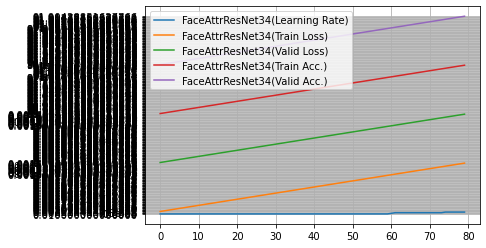

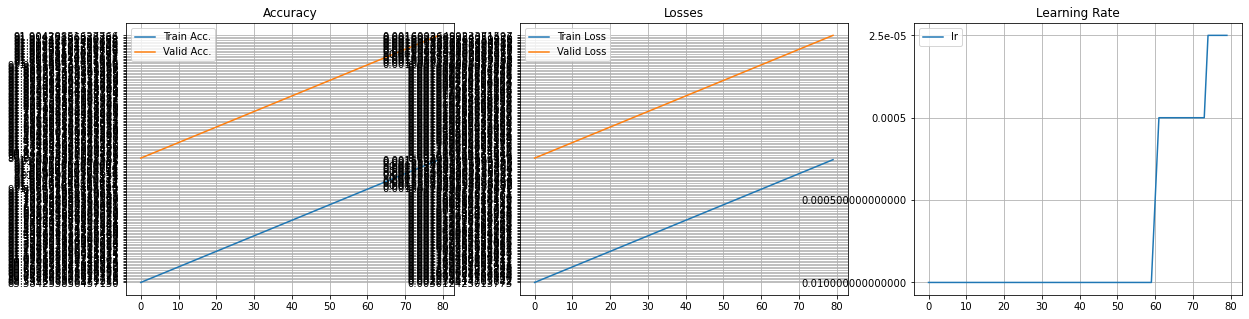

Best accuracy:
91.92190567013145
=> Model trained time: 11:19:15


<Figure size 432x288 with 0 Axes>

In [19]:
# config.epoch = 1
model = create_model(device)
dataloaders, attribute_names = load_dataloaders()
criterion = get_criterion()
optimizer = get_optimizer(model)

print(f"=> Training model: {not config.evaluate}")
if config.evaluate:
    best_prec1, mtimer, _, _, logger, = resume_checkpoint(model, optimizer, config.ckp_logger_fname, config.checkpoint_fname) # checkpoint_fname bestmodel_fname
    #logger.plot_special()
    test_loss, prec1, top1 = validate(dataloaders['test'], model, criterion)
    print(f"=> Best test accuracy: {prec1}, Model val acc: {best_prec1}")
    print_attribute_acc(top1, attribute_names)
else:
    best_prec1, mtimer, lr, start_epoch, logger = resume_checkpoint(model, optimizer, config.ckp_logger_fname, config.ckp_resume)
    run_name, run_time = get_run_name_time(model, criterion, optimizer, comments)
    mtimer = trainer(dataloaders, model, criterion, optimizer, logger, start_epoch, best_prec1, run_name, mtimer)

print(f"=> Model trained time: {mtimer}")

## Testing Loop

In [20]:
if not config.evaluate:
    config.evaluate = True
    model = create_model(device)
    dataloaders, attribute_names = load_dataloaders()
    criterion = get_criterion()
    optimizer = get_optimizer(model)
    
    best_prec1, mtimer, _, _, _, = resume_checkpoint(model, optimizer, config.ckp_logger_fname, config.bestmodel_fname)# config.bestmodel_fname  config.checkpoint_fname
    #print(model)
    test_loss, prec1, top1 = validate(dataloaders['test'], model, criterion)
    print(f"=> Best test accuracy: {prec1}, Model val acc: {best_prec1}")
    print(f"=> Model trained time: {mtimer}")
    print_attribute_acc(top1, attribute_names)

=> creating model 'FaceAttrResNet'
Dataset sizes: {'test': 19962}
Class Labels: 40
=> resuming model: checkpoints\model_best.pth.tar
=> loading checkpoint 'checkpoints\model_best.pth.tar'


  0%|                                                                                          | 0/156 [00:00<?, ?it/s]

=> loaded checkpoint 'checkpoints\model_best.pth.tar' (epoch 69)
=> resuming logger
{'Learning Rate': ['0.010000000000000', '0.010000000000000', '0.010000000000000', '0.010000000000000', '0.010000000000000', '0.010000000000000', '0.010000000000000', '0.010000000000000', '0.010000000000000', '0.010000000000000', '0.010000000000000', '0.010000000000000', '0.010000000000000', '0.010000000000000', '0.010000000000000', '0.010000000000000', '0.010000000000000', '0.010000000000000', '0.010000000000000', '0.010000000000000', '0.010000000000000', '0.010000000000000', '0.010000000000000', '0.010000000000000', '0.010000000000000', '0.010000000000000', '0.010000000000000', '0.010000000000000', '0.010000000000000', '0.010000000000000', '0.010000000000000', '0.010000000000000', '0.010000000000000', '0.010000000000000', '0.010000000000000', '0.010000000000000', '0.010000000000000', '0.010000000000000', '0.010000000000000', '0.010000000000000', '0.010000000000000', '0.010000000000000', '0.010000000000

100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:30<00:00,  5.11it/s]

(156/156) Data: 0.050s | Batch: 0.192s | Total: 0:00:30 | ETA: 0:00:01 | Loss: 0.0017 | top1:  91.4667
=> Best test accuracy: 91.46666163662465, Model val acc: 91.92190567013145
=> Model trained time: 09:48:50
5_o_Clock_Shadow: 94.84019634788397
Arched_Eyebrows: 84.01462775458674
Attractive: 82.89249573426571
Bags_Under_Eyes: 85.31209294149362
Bald: 98.9780583107905
Bangs: 96.18775670340419
Big_Lips: 71.64612762493978
Big_Nose: 84.74100787681898
Black_Hair: 90.41178237353975
Blond_Hair: 96.07253779052148
Blurry: 96.39815646294733
Brown_Hair: 89.09928864461006
Bushy_Eyebrows: 92.60094176111737
Chubby: 95.7869952627705
Double_Chin: 96.43823260762221
Eyeglasses: 99.67438132451659
Goatee: 97.46017429988927
Gray_Hair: 98.15649731055778
Heavy_Makeup: 92.09998997408431
High_Cheekbones: 87.90702334970501
Male: 98.49714457774948
Mouth_Slightly_Open: 94.01362585173426
Mustache: 96.96924152150683
Narrow_Eyes: 87.656547445487
No_Beard: 96.30798513742884
Oval_Face: 75.94429415737314
Pale_Skin: 97.0

## Save & Backup

In [21]:
if ISJUPYTER:
    # Wait for notebook to save
    %autosave 1
    time.sleep(150)
    %autosave 120

Autosaving every 1 seconds


Autosaving every 120 seconds


In [22]:
def backup_everything(run_time, run_name, title, backup_nb=ISJUPYTER):
    # backup checkpoints
    print(f"=> backing up checkpoints... ")
    run_dir = os.path.join(config.BACKUP_DIR, run_name, run_time)
    create_dir_ifne(run_dir)
    fromDirectory = config.CHECKPOINT_DIR
    toDirectory = run_dir
    copy_tree(fromDirectory, toDirectory)
    
    if backup_nb:
        print(f"=> backing up notebook... ")
        # backup notebook html
        nb_name = title + '.ipynb'
        html_name = title + '.html'
        save_name = os.path.join(run_dir, html_name)
        !jupyter nbconvert --to html $nb_name
        shutil.move(html_name, save_name)
    
backup_everything(run_time, run_name, title, backup_nb=ISJUPYTER)

=> backing up checkpoints... 
=> backing up notebook... 


[NbConvertApp] Converting notebook ai6126-project1-colab-v1.2.ipynb to html
[NbConvertApp] Writing 1070667 bytes to ai6126-project1-colab-v1.2.html


In [23]:
if config.auto_hibernate and False:
    os.system('shutdown -h')